<a href="https://colab.research.google.com/github/Maximilianwte/GenAI-Course/blob/main/BDD_GenAI_Train_Stable_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Maximilianwte/GenAI-Course.git
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/examples/dreambooth/train_dreambooth.py
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/scripts/convert_diffusers_to_original_stable_diffusion.py
%pip install -qq git+https://github.com/ShivamShrirao/diffusers
%pip install -q -U --pre triton
%pip install -q accelerate transformers ftfy bitsandbytes==0.35.0 gradio natsort safetensors xformers
!pip install --upgrade diffusers -qq
!pip uninstall bitsandbytes -y -qq
!pip install bitsandbytes -qq
import os
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
import torch
from torch import autocast
import numpy as np

fatal: destination path 'GenAI-Course' already exists and is not an empty directory.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
MODEL_NAME = "runwayml/stable-diffusion-v1-5"
OUTPUT_DIR = "/content/Test_Model"
!mkdir -p $OUTPUT_DIR

In [3]:
!python3 train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --pretrained_vae_name_or_path="stabilityai/sd-vae-ft-mse" \
  --output_dir=$OUTPUT_DIR \
  --instance_data_dir='/content/GenAI-Course/Datasets/maskot-images' \
  --instance_prompt='a photo of xyzobject' \
  --seed=1 \
  --resolution=512 \
  --train_batch_size=2 \
  --train_text_encoder \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --gradient_accumulation_steps=1 \
  --learning_rate=5e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --max_train_steps=800 \
  --save_min_steps=400 \
  --save_interval=200

2024-10-24 09:15:18.279166: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-24 09:15:18.337154: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-24 09:15:18.347807: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-24 09:15:20.084034: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(*

In [5]:
pipe = StableDiffusionPipeline.from_pretrained(f'{OUTPUT_DIR}/800', torch_dtype=torch.float16).to("cuda")
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
g_cuda = torch.Generator(device='cuda')

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/60 [00:00<?, ?it/s]

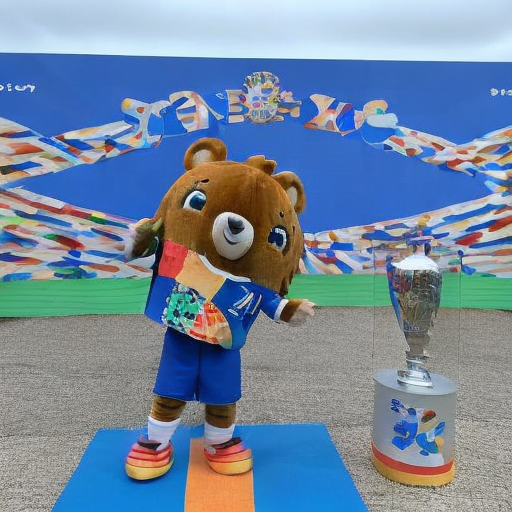

In [6]:
prompt = "a photo of xyzobject"
negative_prompt = ""

seed = np.random.randint(1, 1000)
g_cuda.manual_seed(seed)
guidance_scale = 7
with autocast("cuda"), torch.inference_mode():
    images = pipe(prompt, negative_prompt=negative_prompt, num_images_per_prompt=1, height=512, width=512, num_inference_steps=60, guidance_scale=guidance_scale, generator=g_cuda).images

images[0]